# Mistral_AI (Mixture of Experts)

By Alberto Valdes.

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using A100 GPU.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Explanation:

**Mixture of Experts:**

Mixture of experts (MoE) is a machine learning technique where multiple expert networks (learners) are used to divide a problem space into homogeneous regions It differs from ensemble techniques in that for MoE, typically only one or a few expert models are run for each input, whereas in ensemble techniques, all models are run on every input.


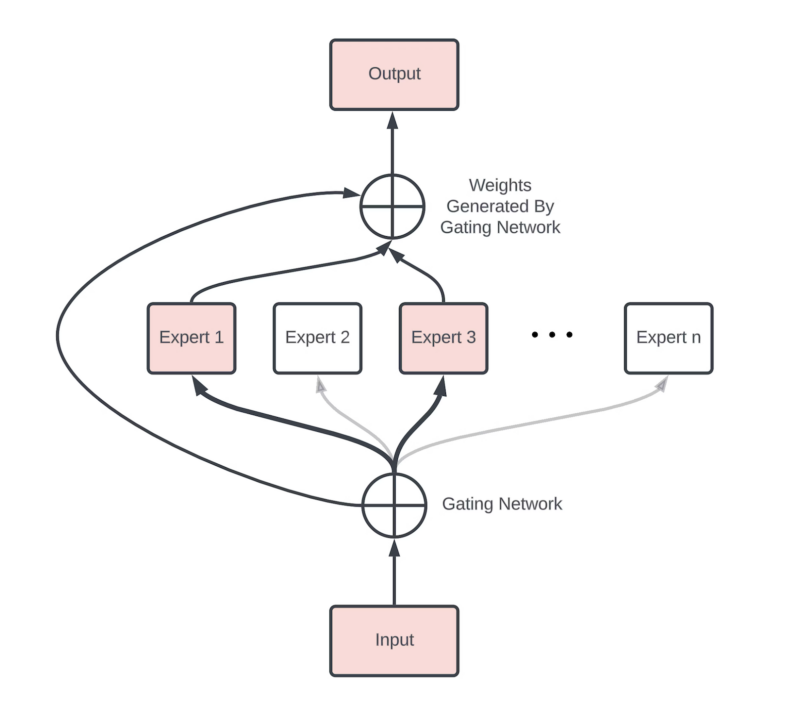

In [4]:
display_img('MoE.png', 10, 10)

In [5]:
start = time.time()

# Finetunning

### a. Setting the environment

In [6]:
!pip install -q -U torch=='2.0.0'

In [7]:
!pip install -q -U accelerate=='0.25.0' peft=='0.7.1' bitsandbytes=='0.41.3.post2' transformers=='4.36.1' trl=='0.7.4'

In [8]:
import os

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### b. Import Libraries

In [10]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

### c. Import Dataset

In [11]:
filename = "Data/all-data.csv"

In [12]:
df = pd.read_csv(filename, names = ["sentiment", "text"], encoding = "utf-8", encoding_errors = "replace")

In [13]:
df.shape

(4846, 2)

In [14]:
X_train = list()
X_val = list()
X_test = list()

In [15]:
for sentiment in ["positive", "neutral", "negative"]:

  train, test = train_test_split(df[df.sentiment == sentiment], train_size = 300, test_size = 300, random_state = 42)
  val, test = train_test_split(test[df.sentiment == sentiment], train_size = 150, test_size = 150, random_state = 42)

  X_train.append(train)
  X_val.append(val)
  X_test.append(test)

In [16]:
X_train = pd.concat(X_train)
X_val = pd.concat(X_val)
X_test = pd.concat(X_test)

In [17]:
def generate_prompt(data_point):
    return f"""
            [INST]Analyze the sentiment of the news headline enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative"[/INST]

            [{data_point["text"]}] = {data_point["sentiment"]}
            """.strip()

In [18]:
def generate_test_prompt(data_point):
    return f"""
            [INST]Analyze the sentiment of the news headline enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative"[/INST]

            [{data_point["text"]}] = """.strip()

In [19]:
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis = 1), columns = ["text"])

In [20]:
X_val = pd.DataFrame(X_val.apply(generate_prompt, axis = 1), columns = ["text"])

In [21]:
y_true = X_test.sentiment

In [22]:
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis = 1), columns = ["text"])

In [23]:
print(X_train['text'].iloc[0])

[INST]Analyze the sentiment of the news headline enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative"[/INST]

            [( ADP News ) - Feb 12 , 2009 - Finnish IT solutions provider Affecto Oyj ( HEL : AFE1V ) said today its net profit rose to EUR 8.5 million ( USD 11m ) in 2008 from EUR 7 million in 2007 .] = positive


In [24]:
print(X_val['text'].iloc[0])

[INST]Analyze the sentiment of the news headline enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative"[/INST]

            [Operating profit totalled EUR 7.0 mn , up from a loss of EUR 4.0 mn in the second quarter of 2009 .] = positive


In [25]:
print(X_test['text'].iloc[0])

[INST]Analyze the sentiment of the news headline enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative"[/INST]

            [Finnish Outotec has been awarded a contract to supply a new zinc roaster with gas cleaning and sulphuric acid plant for the OZK Kardzhali zinc smelter in Bulgaria .] =


In [26]:
y_true.iloc[0]

'positive'

In [27]:
train_data = Dataset.from_pandas(X_train)
val_data = Dataset.from_pandas(X_val)

In [28]:
def evaluate(y_true, y_pred):

  labels = ['positive', 'neutral', 'negative']

  mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}

  def map_func(x):

    return mapping.get(x, 1)

  y_true = np.vectorize(map_func)(y_true)
  y_pred = np.vectorize(map_func)(y_pred)

  # Calculate accuracy

  accuracy = accuracy_score(y_true = y_true, y_pred = y_pred)

  print(f'Accuracy: {accuracy:.3f}')

  # Generate accuracy report
  unique_labels = set(y_true)  # Get unique labels

  for label in unique_labels:

      label_indices = [i for i in range(len(y_true)) if y_true[i] == label]
      label_y_true = [y_true[i] for i in label_indices]
      label_y_pred = [y_pred[i] for i in label_indices]
      accuracy = accuracy_score(label_y_true, label_y_pred)
      print(f'Accuracy for label {label}: {accuracy:.3f}')

  # Generate classification report
  class_report = classification_report(y_true = y_true, y_pred = y_pred)
  print('\nClassification Report:')
  print(class_report)

  # Generate confusion matrix
  conf_matrix = confusion_matrix(y_true = y_true, y_pred = y_pred, labels = [0, 1, 2])
  print('\nConfusion Matrix:')
  print(conf_matrix)

### e. Load the model

In [29]:
!pip install huggingface_hub

In [30]:
from huggingface_hub import notebook_login

In [31]:
notebook_login()

In [32]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

In [33]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    load_4bit_use_double_quant = False,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_compute_dtype = torch.bfloat16
    )

In [34]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config = bnb_config,
    device_map = "auto"
    )

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
model.config.use_cache = False
model.config.pretraining_tp = 1

In [36]:
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          trust_remote_code = True,
                                          padding_side = 'left',
                                          add_bos_token = True,
                                          add_eos_token = True
                                          )

In [37]:
tokenizer.pad_token = tokenizer.eos_token

In [38]:
def inference_model(model, tokenizer, text):

  pipeline = transformers.pipeline(
      task = "text-generation",
      model = model,
      tokenizer = tokenizer,
      max_new_tokens = 1,
      temperature = 0.0
      )

  sequences = pipeline(
      text,
      pad_token_id = tokenizer.eos_token_id
      )

  all_txt = ""

  for seq in sequences:

    all_txt = all_txt + seq['generated_text']

  return all_txt

In [39]:
y_pred = []

for i in tqdm(range(len(X_test))):

  y_pred.append(inference_model(model, tokenizer, X_test['text'].iloc[i]).split(' = ')[1])

100%|██████████| 450/450 [00:50<00:00,  8.99it/s]


In [40]:
y_pred = pd.Series(y_pred)
y_pred.index = y_true.index

In [41]:
evaluate(y_true, y_pred)

Accuracy: 0.489
Accuracy for label 0: 0.480
Accuracy for label 1: 0.973
Accuracy for label 2: 0.013

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.48      0.64       150
           1       0.39      0.97      0.56       150
           2       1.00      0.01      0.03       150

    accuracy                           0.49       450
   macro avg       0.78      0.49      0.41       450
weighted avg       0.78      0.49      0.41       450


Confusion Matrix:
[[ 72  78   0]
 [  4 146   0]
 [  0 148   2]]


### f. QLoRA

In [42]:
peft_config = LoraConfig(
    lora_alpha = 16,
    lora_dropout = 0.1,
    r = 64,
    bias = "none",
    task_type = "CAUSAL_LM"
    )

In [43]:
num_epochs = 3

In [44]:
training_arguments = TrainingArguments(
    output_dir = "logs",
    num_train_epochs = num_epochs,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 8,
    optim = "paged_adamw_32bit",
    save_steps = 0,
    logging_steps = 25,
    learning_rate = 2e-4,
    weight_decay = 0.001,
    fp16 = True,
    bf16 = False,
    max_grad_norm = 0.3,
    max_steps = -1,
    warmup_ratio = 0.03,
    group_by_length = True,
    lr_scheduler_type = "cosine",
    report_to = "tensorboard",
    evaluation_strategy = "epoch"
    )

In [45]:
trainer = SFTTrainer(
    model = model,
    train_dataset = train_data,
    eval_dataset = val_data,
    peft_config = peft_config,
    dataset_text_field = "text",
    tokenizer = tokenizer,
    args = training_arguments,
    packing = False,
    max_seq_length = 1024
    )

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

### g. Train

In [46]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
0,0.806000,0.864868
2,0.656200,0.799421


TrainOutput(global_step=336, training_loss=0.8528859288919539, metrics={'train_runtime': 802.5563, 'train_samples_per_second': 3.364, 'train_steps_per_second': 0.419, 'total_flos': 1.2149615895158784e+16, 'train_loss': 0.8528859288919539, 'epoch': 2.99})

### h. Evaluate Performance

In [47]:
y_pred = []

for i in tqdm(range(len(X_test))):

  y_pred.append(inference_model(model, tokenizer, X_test['text'].iloc[i]).split(' = ')[1])

100%|██████████| 450/450 [00:57<00:00,  7.87it/s]


In [48]:
y_pred = pd.Series(y_pred)
y_pred.index = y_true.index

In [49]:
evaluate(y_true, y_pred)

Accuracy: 0.862
Accuracy for label 0: 0.980
Accuracy for label 1: 0.760
Accuracy for label 2: 0.847

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       150
           1       0.87      0.76      0.81       150
           2       0.83      0.85      0.84       150

    accuracy                           0.86       450
   macro avg       0.86      0.86      0.86       450
weighted avg       0.86      0.86      0.86       450


Confusion Matrix:
[[147   2   1]
 [ 11 114  25]
 [  8  15 127]]


### Time of execution

In [50]:
end = time.time()

In [51]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 15 minutes and 47 seconds.
